# Exploring Large Image Datasets with Image Embeddings

This notebook builds a standalone visualisation of a set of images you upload in a zip file. It is inspired by the Image Machine [1]

It will apply off-the-shelf algorithms for representing your images as a compact set of a numbers [(an embedding of the images in a vector space)](TODO: link to a wikipedia page). The resulting representation of the images is used to organise and visualise the relationships between the images you upload, *with respect to* the specific embedding algorithm chosen.  

## Supported "Embeddings"

This notebook supports generating the following embeddings for your uploaded images:

- colour histograms
- VGG
- CLIP [TODO: cite all of these.] - one sentence description 

## What You'll Need

A `.zip` file containing images. This may contain nested folders, non-image files etc. as they will be filtered out. 

Provide some guidance around how long it will take. - Take timings from later and put into a table

### Don't Have a Dataset Yet?

Try out these example datasets:

- add links from zenodo + brief description
- ultrasounds images





If you are familiar with jupyter notebooks please start running the notebook from [section 0](#0-import-dependencies), otherwise the following aims to give you a quickstart guide.

1. Jupter notebooks are made up of 'cells,' these are either 'code' (python in this case ), or 'text' (markdown) cells.
2. To run a cell you can either click on the run symbol in a cell, or use `shift`+`enter`.

# 0. Import Dependencies

This notebook includes many functions in different files, feel free to explore them.

First run the following cell (`shift`+`enter`) to import the required libraries/functions.

In [ ]:
# General
import numpy as np

# Image processing
from PIL import Image
import os 
import zipfile

### Embedding options ###
## VGG16 ##
from torch.utils.data import DataLoader
from dataset import ImageDataset
from torchvision import transforms
import torch
from torchvision import models

## Plotting ##
import matplotlib.pyplot as plt
import seaborn as sns

# Set random seeds
import random
random.seed(42) 
np.random.seed(42)
torch.manual_seed(42)

# Custom functions
from get_embeddings import get_clip_embedding, get_normalised_histogram, get_embedding, get_embeddings_pytorch
from embeddings_analysis import get_knn, get_count_neighbour_occurances, rank_neighbour_occurances, get_mean_distance, get_cluster_labels
from force_directed_diagram import get_diagram_data #, get_position_df
from get_html import get_html_rendering_details, generate_html

# 1. Load images 

Please upload a single `.zip` file into the `input` folder [here](./input), and then run the following cell to attempt to locate the image zip file.

If you want to upload a new file, you will need to replace your existing uploaded file, or delete it.

In [ ]:
input_files = os.listdir('./input')
if len(input_files) == 2:
    if not (input_files[0].endswith('.zip') or input_files[1].endswith('.zip')):
        print("Single file in input folder (excluding .gitkeep) is not a .zip file")

    else:
        for file in input_files:
            if file.endswith('.zip'):
                # therefore there is one zip file 
                IMAGE_ZIP = "./input/" + file
                print(f"Successfully found file '{file}'.")
else:
    print("One file not found in the input folder (excluding .gitkeep)")

Please run this cell to setup image parsing preferences, and to test image detections.

 You may edit `IMAGE_EXTENSIONS` if you wish to exclude/include particular filename suffixes. You may also edit `IMAGE_IGNORE` to exclude certain filename prefixes (e.g. `._` is a metadata filename prefix).

In [ ]:
# adjust these to desired values (Zip file images will be read from)
IMAGE_EXTENSIONS = (".jpg", ".JPG", ".png",".PNG", ".JPEG", ".jpeg") # The filename suffixes to be included
IMAGE_IGNORE = ("._", ) # filename prefixes to be excluded "._" is for metadata

# Display how many images are detected in the zip file. #! ADD WITH and do it later also
imgzip = zipfile.ZipFile(IMAGE_ZIP)
print(f"{len([name for name in imgzip.namelist() if name.endswith(IMAGE_EXTENSIONS) and not name.split('/')[-1].startswith(IMAGE_IGNORE)])} images detected.")
del imgzip
#! also display first 10 filenames etc.

250 images detected.


The following cell is example code for displaying the first image in the zip file. Please run it to see your image and its filename appear below.

Rome Weather/Cloudy/download (1).jpg


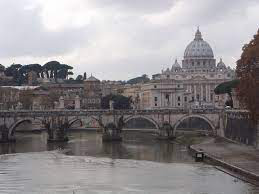

In [17]:
imgzip = zipfile.ZipFile(IMAGE_ZIP)
for name in imgzip.namelist():
    if name.endswith(IMAGE_EXTENSIONS) and not name.split("/")[-1].startswith(IMAGE_IGNORE):
        with Image.open(imgzip.open(name)) as img:
            print(name)
            display(img)
            break
del imgzip, name, img

# 2. Embed images
In this section we go over methods to convert our images into a 1D array of numbers (or an N-dimensional vector). There are many ways that this is done, and this notebook aims to allow for explicit comparisons between how different embedding methods "see" images.

The following are simply examples, and you are more than welcome to adjust the existing code to fit your needs, or to import your own embeddings. The format is a 2D array, where each row is a different image (with the ith row in `embedding` corresponding to the ith filename in `image_filenames`).

EXPLAIN THE PURPOSE OF THIS SECtion (if you want to modify) AND SKIP LINK TO RUNNING EMBEDDINGS

The custom functions described in this section can be found in [get_embeddings.py](./get_embeddings.py).

### 2.1 Basic no-batch embedding
The following provides code examples for how to do simple no-batch embedding. This means each image is iterated over individually. This will work in almost all cases, however may not be the most efficient. The `get_embedding` function does utilise multithreading.

The following is an example of how to use the `get_embedding` function. It takes 3 parameters, the two constants defined above, and an `embedding_function`. This function must take in a `PIL.Image` object and return a 1D array of floats (it is crucial that this array is the same length for every image).

The example `embedding_function` provided is `get_normalised_histogram`, but this can be swapped out to whatever you wish as long as it fulfills the above criteria.

(This code is not crucial to the notebook, so you are welcome to set `skip` to `True` if you wish.)

In [ ]:
# This should take about 15 seconds to run for 1000 images
skip = False
if not skip:
    embedding_function = get_normalised_histogram
    embedding, image_filenames = get_embedding(image_zip=IMAGE_ZIP, 
                                            image_extensions=IMAGE_EXTENSIONS, 
                                            image_ignore=IMAGE_IGNORE,
                                            embedding_function=embedding_function) 
    print(embedding[0:5], image_filenames[0:5])
    del embedding, image_filenames

### 2.2 Batch embedding (pytorch)
The following will describe how to utilise the existing code for pytorch batch embedding. 

This requires a custom dataset class and dataloader (defined below). It is recommended to play with the `DataLoader` parameters to see what runs best. If you use a pytorch embedder other than one of the VGG's (e.g. VGG16/VGG19) you may have to adjust the `ImageDataset` `transform` attribute to resize to an appropriate size with an appropriate mean and std of that embedder.

The cell defining dataset and dataloader must be run, however the one following it is an example implementation of the `get_embeddings_pytorch` function and may be skipped by setting `skip` to `True` (This is as this may take a while to run and it will be run later anyway). 

In [ ]:
# Import custom tensor dataset from other file
#! skip here and redefine the dataloader later
dataset = ImageDataset(image_zip=IMAGE_ZIP, image_extensions=IMAGE_EXTENSIONS, image_ignore=IMAGE_IGNORE,
                       transform= transforms.Compose([
                           transforms.Resize((224, 224)),  # Resize image to 224x224 pixels
                           transforms.ToTensor(),         # Convert image to tensor
                           transforms.Normalize(          # Normalize using ImageNet statistics
                            mean=[0.485, 0.456, 0.406],  # Mean for RGB channels
                            std=[0.229, 0.224, 0.225]    # Standard deviation for RGB channels
                                )
    ]))

# can look into optimising these values
dataloader = DataLoader(dataset, batch_size=64,
                        shuffle=False, num_workers=0) #,prefetch_factor=2)

This code is skipped by default as 1. It takes a while to run and 2. We will be running it later to produce some of the embeddings.

Note: to adjust the model you may simply swap vgg16 to another pytorch model, listed here: https://pytorch.org/vision/main/models.html
(Please keep in mind the `ImageDataset` `transform`s may need to be changed if you use a non VGG model, so please refer to the documentation for that model.)

In [ ]:
# This should take about 13 minutes to run for 1000 images
skip = True
if not skip:
    pytorch_model = models.vgg16(weights=models.VGG16_Weights.DEFAULT).to("cpu")
    batch_embeddings, image_filenames = get_embeddings_pytorch(dataloader, pytorch_model=pytorch_model)

    print(embedding[0:5], image_filenames[0:5])
    del embedding, image_filenames

### 2.3 Run all embeddings
<!-- This cell runs the 4 default embeddings setup for this notebook. You are more than welcome to adjust this. The CLIP embedding is utilising the `imgbeddings` library: https://github.com/minimaxir/imgbeddings -->

SAY RUN THE BLOCK FOR WHAT YOU WANT EMBEDDINGS FOR

# add header before each one with name of embedding

In [ ]:
%%time
#! Check image_filenames against filenames in IMAGE_ZIP  and if not same then run 
# This should take about 15 seconds to run for 1000 images
#### Get embedding without batching ####
embedding_function = get_normalised_histogram
embedding, image_filenames = get_embedding(image_zip=IMAGE_ZIP, image_extensions=IMAGE_EXTENSIONS, image_ignore=IMAGE_IGNORE, embedding_function=embedding_function) 
np.save("./output/image_embedding_hist.npy", embedding)
np.save("./output/image_filenames_hist.npy", image_filenames) # this is to keep a consistent log of the index

In [ ]:
%%time
# This should take about 13 minutes to run for 1000 images
#### Get embedding with batching (for pytorch) #####
# https://pytorch.org/vision/main/models/vgg.html
# https://pytorch.org/vision/main/models/generated/torchvision.models.vgg16.html#torchvision.models.VGG16_Weights 

# VGG19
pytorch_model = models.vgg19(weights=models.VGG19_Weights.DEFAULT).to("cpu")
batch_embeddings, image_filenames = get_embeddings_pytorch(dataloader, pytorch_model=pytorch_model)
np.save("./output/image_embedding_vgg19.npy", batch_embeddings)
np.save("./output/image_filenames_vgg19.npy", image_filenames)

In [ ]:
%%time
# This should take about 12 minutes to run for 1000 images
#### Get embedding with batching (for pytorch) #####
# https://pytorch.org/vision/main/models/vgg.html
# https://pytorch.org/vision/main/models/generated/torchvision.models.vgg16.html#torchvision.models.VGG16_Weights 

# VGG16
pytorch_model = models.vgg16(weights=models.VGG16_Weights.DEFAULT).to("cpu")
batch_embeddings, image_filenames = get_embeddings_pytorch(dataloader, pytorch_model=pytorch_model)
np.save("./output/image_embedding_vgg16.npy", batch_embeddings)
np.save("./output/image_filenames_vgg16.npy", image_filenames)

In [ ]:
%%time
# This should take about 6 minutes to run for 1000 images
### Get embedding CLIP (inbuilt batching) #### 
clip_embeddings, image_filenames = get_clip_embedding(IMAGE_ZIP, IMAGE_EXTENSIONS, image_ignore=IMAGE_IGNORE, batch_size=32)
np.save("./output/image_embedding_clip.npy", clip_embeddings)
np.save("./output/image_filenames_clip.npy", image_filenames) # this is to keep a consistent log of the index

### 2.4 Load selected embeddings
You may change the value of `embedding_to_load` to load a specific embedding of your choice. This choice will be used when walking through helper functions and visualisations in this notebook.

Please note in section 4 of this notebook there is an option to either generate an output HTML file for just the embedding selected here, or for any number of them at once. If you opt for the second option and don't wish to see examples, you may [skip to generating html](#4-html-export) from here.

In [ ]:
%%time
# this may be either "hist", "vgg16", "vgg19", or "clip"
embedding_to_load = "hist" 
#### Load Embeddings ####
## Colour Histogram ##
if embedding_to_load == "hist":
    embedding = np.load("./output/image_embedding_hist.npy")
    image_filenames = np.load("./output/image_filenames_hist.npy")
## VGG16 ##
elif embedding_to_load == "vgg16":
    embedding = np.load("./output/image_embedding_vgg16.npy")
    image_filenames = np.load("./output/image_filenames_vgg16.npy")
## VGG19 ##
elif embedding_to_load == "vgg19":
    embedding = np.load("./output/image_embedding_vgg19.npy")
    image_filenames = np.load("./output/image_filenames_vgg19.npy")
## CLIP ##
elif embedding_to_load == "clip":
    embedding = np.load("./output/image_embedding_clip.npy")
    image_filenames = np.load("./output/image_filenames_clip.npy")


# 3. Embedding Analysis
In this section we will define some functions to help us analyse the image embeddings. The custom functions described in this section can be found in [embeddings_analysis.py](./embeddings_analysis.py).

### 3.1 Get KNN
In this section we generate the `nearest_neighbours_array` and `neighbours_distance_array` for the desired `number_of_neighbours`. 
The `nearest_neighbours_array` is a 2D array where the ith row represents the ith filename in `image_filenames`, and each row lists the desired N nearest neighbours for that specific image.
The `neighbours_distance_array` is similar to the `nearest_neighbours_array`, however lists the neigbour distance.

Below is an example implementation, it shouldn't take long to run.

In [ ]:
%%time
# This should take about 30 seconds to run for 1000 images
number_of_neighbours = 10
nearest_neighbours_array, neighbours_distance_array = get_knn(embedding, number_of_neighbours)

nearest_neighbours_array[0:3], neighbours_distance_array[0:3]

### 3.2 Make some analysis helper functions
The first helper function is `get_count_neighbour_occurances`. This function takes the `nearest_neighbour_arary` and returns an array where the ith index is how many times that index appeared as a neighbour (including as a neighbour of itself).

In [ ]:
count_neighbour_occurance_array = get_count_neighbour_occurances(nearest_neighbours_array=nearest_neighbours_array)
count_neighbour_occurance_array[0:10]

Next up we have `rank_neighbour_occurances`, which takes the previously defined `count_neighbour_occurance_array` as an input, and returns an array where the ith value in the array indicates that the index stored there is the ith most common or ith least common neighbour, depending on if the `ascending` parameter is set to `True` or `False` (`True` by default).

In [ ]:
ranked_neighbour_occurance_array = rank_neighbour_occurances(count_neighbour_occurance_array, ascending=True)
print(f"The most common neighbour is at image_filenames index {ranked_neighbour_occurance_array[-1]}") # The last value as ascending
ranked_neighbour_occurance_array[0:10]

`get_mean_distance` takes in the previously described `neighbours_distance_array` and returns a 1D array where the ith index indicates the ith images mean distance from all of its N nearest neighburs. You may choose whether this calculation should include itself as a neighbour (as each image is always its own closest neighbour) by setting the boolean value of `exclude_self` (`True` by default).

In [ ]:
get_mean_distance(neighbours_distance_array, exclude_self=True)[0:10]

### 3.2 Getting K-means clusters
These will be used as an additional visualisation option for the images.

The `get_cluster_labels` function takes in `embedding` (the image embedding array) and `n_clusters` (desired number of clusters, by default 10). If you wish you may also change the `random_state`. This function returns a 1D array, where the ith index indicates what cluster the ith image lies in. (e.g. 0th cluster, 1st cluster...)

In [ ]:
%%time
cluster_labels = get_cluster_labels(embedding, n_clusters=20)
cluster_labels[0:10]

# swwap 3 and 4, and then load 1 embedding after, and then load embedding to explore one embedding in detail

# 4. HTML Export 
Create a "summary" HTML document. What this document contains is better described within the file. If running in binderhub, please right click + `Open in New Browser Tab` the html file to ensure the javascript runs as expected. 

The main options are the following: `colour_map` (the variable that describes how different clusters are coloured) is set to `"tab20"` by default but it may be set to any of the options avaliable when running `from matplotlib import colormaps` and `list(colormaps)` (for over 20 clusters you would need to use a continous map like `"viridis"`).

You may also select if you would like your images to be grouped by cluster when displayed. The `group_cluster` parameter has the following options:
- `False`: Sort by rank normally
- `True`: Order by Cluster label order
- `asc`: Sort by ascending cluster size order
- `desc`: Sort by descending cluster size order
- `rank`: Sort by the highest ranked image in each cluster

Please note the HTML is fully self contained, meaning after it is created it has the images and required packages encoded within it. This is so the HTML can be easily shared, and will still be runnable without internet access.

The custom functions described in this section can be found in [get_html.py](./get_html.py).

In the following cell you can change the boolean value of `generate_all` to select one of the following:
- `True`: generate a html file for each embedding in `embedding_name_list`.Note that the name in `embedding_name_list` refers to the name used when saving the embedding + image_filenames. This can be run immediately after saving the embeddings, and does not require any of the cells inbetween. 

- `False`: generate a single html file using the values from sections 2 and 3. This means it will use the embedding type you chose to load, the number of clusters or nearest neighbours you selected etc. This option requires running the cells up to this point. 

In [ ]:
%%time

#! remove generate all 
generate_all = True
# generate_all = True: Should take about 4 minutes to run for 1000 images and 4 embeddings.
# generate_all = False: Should take about 1 minute to run for 1000 images and 1 embedding.
## Settings for both options ##
group_clusters='rank'
colour_map="tab20"

## generate_all=True specific options ## 
# Please ensure that the embeddings have been created for all embeddings in the list
#! remove the list and base it off all the embeddings avaliable in /output
embedding_name_list = ['hist', 'vgg19','vgg16', 'clip']
number_of_neighbours=10
n_clusters=20


if generate_all:
    for embedding_name in embedding_name_list:
        html_file = generate_html(*get_html_rendering_details(embedding_name, IMAGE_ZIP, IMAGE_EXTENSIONS, IMAGE_IGNORE, number_of_neighbours=number_of_neighbours, n_clusters=n_clusters), 
                group_clusters=group_clusters, 
                colour_map=colour_map)

        with open(f"./output/output_{embedding_name}.html",'w') as file:
            file.write(html_file)
            del html_file, file

        print(f"Completed export for {embedding_name}")


elif not generate_all:
    diagram_data = get_diagram_data(nearest_neighbours_array, neighbours_distance_array, cluster_labels, image_filenames, return_json=True)

    html_file = generate_html(nearest_neighbours_array, neighbours_distance_array, IMAGE_ZIP, IMAGE_EXTENSIONS, IMAGE_IGNORE, diagram_data, cluster_labels, group_clusters=group_clusters, colour_map=colour_map)

    with open("./output/output.html",'w') as file:
        file.write(html_file)

    del html_file, diagram_data, file

Now that you have generated the html output files, they can be found in [./output](./output). If running in binderhub, please right click + `Open in New Browser Tab` the html file to ensure the javascript runs as expected. Or you may download them.

# 5. Data exploration
This following section aims to serve as an example of some visualisation options. Feel free to add your own here. 
Please note this section depends on the running of sections 2 and 3.

First, lets graph the most common neighbours

### 5.1 Most common neighbours

In [ ]:
count_neighbour_occurances_array = get_count_neighbour_occurances(nearest_neighbours_array)
ranked_neighbour_occurances = rank_neighbour_occurances(count_neighbour_occurances_array, ascending=False)

n_most_common = 10
x=[image_filenames[idx] for idx in ranked_neighbour_occurances[0:n_most_common]]
y=[count_neighbour_occurances_array[idx] -1 for idx in ranked_neighbour_occurances[0:n_most_common]] # the -1 is to exclude counting being its own neighbour
del count_neighbour_occurances_array, ranked_neighbour_occurances
plt.figure(figsize=(10,5))

sns.barplot(x=x, y=y)

plt.xticks(rotation=270)
plt.xlabel("Image names")
plt.ylabel("Neighbour Counts (excluding being its own neighbour)")
plt.title(f"{n_most_common} most common image neighbours (descending) for 10 nearest neighbours (9 excluding self)")

plt.show()
print(x[0]) # the filename for the most common image 

Display the most common image neighbour.

In [ ]:
imgzip = zipfile.ZipFile(IMAGE_ZIP)
with Image.open(imgzip.open(x[0])) as img:
    display(img)

### 5.2 Closest image to its neighbours (average)

In [ ]:
neighbours_mean_distance_array = get_mean_distance(neighbours_distance_array)
ranked_neighbour_occurances = rank_neighbour_occurances(neighbours_mean_distance_array, ascending=True)

n_most_common = 10
x=[image_filenames[idx] for idx in ranked_neighbour_occurances[0:n_most_common]]
y=[neighbours_mean_distance_array[idx] for idx in ranked_neighbour_occurances[0:n_most_common]] # the -1 is to exclude counting being its own neighbour
del neighbours_mean_distance_array, ranked_neighbour_occurances
plt.figure(figsize=(10,5))

sns.barplot(x=x, y=y)

plt.xticks(rotation=270)
plt.xlabel("Image names")
plt.ylabel("Mean distance from neighbours (excluding itself)")
plt.title(f"{n_most_common} images with the smallest mean distance from 10 nearest neighbours (excluding self)")

plt.show()
print(x[0])

Display the closest image neighbour.

In [ ]:
imgzip = zipfile.ZipFile(IMAGE_ZIP)
with Image.open(imgzip.open(x[0])) as img:
    display(img)

### 5.3 Histogram for times an image appears as a nearest neighbour
This graph is worth noting in particular for different embeddings, some have much more even distributions than others.

In [ ]:
sorted_count_neighbour_occurances_array = np.sort(get_count_neighbour_occurances(nearest_neighbours_array))-1 # -1 to exclude self

plt.figure(figsize=(10,5))

sns.histplot(x=sorted_count_neighbour_occurances_array, kde=True, bins=30)
plt.xticks(rotation=270)
plt.xlabel(f"Number of nearest neighbour occurances excluding self ({number_of_neighbours} nearest neighbours)")
plt.ylabel("Count")
plt.title(f"Nearest neighbour count histogram for {number_of_neighbours} nearest neighbours")

plt.show()
del sorted_count_neighbour_occurances_array


### 5.4 Histogram for an images mean distance across its neighbours

In [ ]:
log = False

if log:
    sorted_mean_distance_array = np.log(np.sort(get_mean_distance(neighbours_distance_array)))
    title = "Log mean"
else:
    sorted_mean_distance_array = np.sort(get_mean_distance(neighbours_distance_array))
    title = "Mean"

plt.figure(figsize=(10,5))

sns.histplot(x=sorted_mean_distance_array, kde=True, bins=30)

plt.xticks(rotation=270)
plt.xlabel(f"{title} distance from nearest neighbours excluding self ({number_of_neighbours} nearest neighbours)")
plt.ylabel("Count")
plt.title(f"{title} neighbour distance histogram for {number_of_neighbours} nearest neighbours")

plt.show()
del sorted_mean_distance_array

### 5.5 Visualise the embeddings for the most and least common nearest neighbours

A bar graph to physically view the differences between the most and least common image neighbours. Please note these graphs don't always work due to handling of extreme values.

In [ ]:
count_neighbour_occurances_array = get_count_neighbour_occurances(nearest_neighbours_array)
max_index = np.argmax(count_neighbour_occurances_array)

plt.bar(np.arange(len(embedding[max_index])), embedding[max_index])
plt.title("Embedding for highest neighbour image")
plt.show()
print(image_filenames[max_index])

In [ ]:
min_index = np.argmin(count_neighbour_occurances_array)

plt.bar(np.arange(len(embedding[min_index])), embedding[min_index])
plt.title("Embedding for lowest neighbour image")
plt.show()
del count_neighbour_occurances_array
print(image_filenames[min_index])

### 5.6 Force directed diagram code
This section was originally to create an interactive "network plot" with a heatmap for aid in visualisation, using different colours for each points cluster. 

The code for viewing these plots can be seen commented out in [force_directed_diagram.py](./force_directed_diagram.py), however the same visualisation are avaliable in the output html documents [created in section 4](#4-html-export) (**this is the recommended way to view these graphs**).

The example code shown in this section is use to create the diagrams for the output html file. 

The `get_diagram_data` function returns all the data needed to construct the force directed diagram, taking in a variety of previously defined data. Setting `return_json` to `True` will return a string (this is used for generating the HTML).

In [ ]:
diagram_data = get_diagram_data(nearest_neighbours_array, neighbours_distance_array, cluster_labels, image_filenames, return_json=False)
print(diagram_data.keys()) # showing keys as the actual dictionary is very large
del diagram_data

### 5.7 Pie chart for images in each cluster
This chart was created to help visualise the differences in cluster sizes.

In [ ]:
labels, counts = np.unique(cluster_labels, return_counts=True) 

plt.pie(counts, labels=labels, autopct='%.2f%%')
del labels, counts
plt.title("Images in each cluster")
plt.show()

## Exploration advice - some things to look for 
The following is a list of some general things that tend to be interesting within this notebooks visualisations.
I would recommend investigating the following:


1. The distribution of the nearest neighbour count histogram
    - Some embeddings tend to be much more skewed than others

2. Mean distance histogram 
    - Some distributions appear more normal than others.

3. The difference in embedding between the most and least neighbour occurance images.
    - Is one more even than the other? etc.

4. The general theme of clusters (from setting `group_clusters` to not `False`)
    - Some clusters have very explicit themes 

5. The 'arms' and 'clusters' in the force directed diagram
    - Using the selection tool in the notebook to see if there are themes to arms and clusters
    - Compare how these themes differ to the cluster themes 
    - What sort of images appear in the main hotspots?

6. You can change the amount of neighbours for different advantages in the force directed diagram.
    - Lower neighbours will create more branches, as it isolates small "groups"
    - Higher neighbours will be more central, but accentuate the very different groups 